# Neuron Construction with STDP Convergence Predictions

This document gives an example of constructing spiking neurons that detect activity patterns using predictions of spike-timing-dependent plasticity convergence.
Simulated experiments performed by Masquelier et al. (2008a, 2008b) have demonstrated that adapting synapses through spike-timing-dependent plasticity can tune neurons to detect one or more patterns of spikes concealed in the input activity.

Input activity with concealed patterns of spikes will be generated and neurons construct neurons that spike at a specific times in response to concealed patterns.
First, let's simulate some input activity and see how a model of a spiking neurons responds to that activity.

## Presynaptic Spike-Time Generation

The input activity used in these experiments is pregenerated.
First the simulation time is divided into segments. 
Segments are then randomly assigned to patterns until 1/3 of the segments contain a pattern.
The same spike pattern cannot occur consecutively and only one pattern is present at a time.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

sim_time = 67500  # 150 repetition for 3 patterns
dt = 1
pattern_n = 3

#pre-selecting the segments of simulation activity that will have a repetition of a pattern
segment_time = 50
segment_steps = segment_time//dt
segment_n = sim_time//segment_time
segment_available = np.full((segment_n, pattern_n), True)
pattern_repeat_n = segment_n//(3 * pattern_n)
pattern_segment_ind = np.zeros((pattern_repeat_n, pattern_n), dtype='int')
pattern_segment_list = np.zeros((pattern_repeat_n*pattern_n,2), dtype='int')

pattern_seq = np.arange(3)
for repeat_n in range(pattern_repeat_n):
    np.random.shuffle(pattern_seq)
    for p in pattern_seq:
        available = np.argwhere(segment_available[:,p])
        segment_select = np.random.choice(available.flatten())
        pattern_segment_ind[repeat_n,p] = segment_select
        segment_available[segment_select,:] = False
        if segment_select > 0:
            segment_available[segment_select-1,p] = False
        if segment_select < segment_n-1:
            segment_available[segment_select+1,p] = False
    pattern_segment_list[repeat_n*pattern_n:(repeat_n+1)*pattern_n:1, 0] = pattern_segment_ind[repeat_n,:]
    pattern_segment_list[repeat_n*pattern_n:(repeat_n+1)*pattern_n:1, 1] = np.arange(3, dtype='int')


pattern_segment_ind.sort(axis=0)
pattern_segment_base = np.zeros(pattern_n, dtype='int')
for p in range(pattern_n):
    pattern_segment_base[p] = pattern_segment_ind[np.random.randint(pattern_repeat_n),p]
pattern_segment_list = np.array(pattern_segment_list[pattern_segment_list[:,0].argsort(axis=0),:])
print('Pattern repetition segements selected')
print('Base patterns occur in segments: ' + str(pattern_segment_base))

Pattern repetition segements selected
Base patterns occur in segments: [ 463  417 1023]


Once each pattern is assigned to segments of the simulation, the spike-times are generated in 1ms increments.
Each neurons had a spike-rate variable in the range of 0-90Hz.
This spike-rate is used to calculate probability of a spike in the 1ms increment.
Spike-rates are updated in each time-step.
Spike-patterns are copied from this randomly generated activity and pasted into the segments cotntaining pattern repetitions with jitter.
A further 10Hz random spike-noise activity is added to all neurons.

In [2]:
n_pre = 2000      # presynaptic neurons
n_pattern = 1000  # presynaptic neurons in each pattern
pattern_neuron_mask = np.full((n_pre, pattern_n), False)  # a boolean mask to select pattern neurons
for p in range(pattern_n):
    pattern_neuron_mask[:,p] = np.random.randint(2, size=n_pre, dtype=bool)

steps_silent_max = 50
steps_silent = np.random.randint(steps_silent_max, size=n_pre)

spike_times_list_max = sim_time//5
spike_times_list_count = np.zeros(n_pre, dtype='int')
spike_times_list = np.full((n_pre, spike_times_list_max), np.inf)

spike_times_list_pattern_max = 20
spike_times_list_pattern_count = np.zeros((n_pre, pattern_n), dtype='int')
spike_times_list_pattern = np.full((n_pre, spike_times_list_pattern_max, pattern_n), np.inf)    
    
r_max = 90 # maximum firing rate (Hz)
r_min = 0  # minimum firing rate (Hz)

rd_max = 1800   # maximum FR speed (Hz/s)
rd_min = -1800  # minimum FR speed (Hz/s)

rdd_max = 360   # maximum FR acceleration (Hz/s^2) 
rdd_min = -360  # minimum FR acceleration (Hz/s^2)

r_noise = 10    # additional noise firing rate

rate = (r_max - r_min) * np.random.rand(n_pre) + r_min
rate_d = (rd_max - rd_min) * np.random.rand(n_pre) + rd_min

pattern_segment_next = 0
pattern_segment_list_shape = pattern_segment_list.shape
print('Generating background activity and base patterns:')
for sim_step in range(sim_time):
    if (sim_step % 1000) == 0:
        print('Seconds generated: ' + str(sim_step / 1000) + '/' + str(sim_time / 1000) + 's')
    sim_segment = sim_step // segment_time
    rdd = (rdd_max - rdd_min) * np.random.rand(n_pre) + rdd_min
    rate_d = np.maximum(rd_min, np.minimum(rd_max, rate_d + rdd))
    rate = np.maximum(r_min, np.minimum(r_max, rate + rate_d/1000))
    steps_silent += 1
    
    f = np.logical_or((rate/1000 > np.random.rand(n_pre)), (steps_silent >= steps_silent_max))
    steps_silent[f] = 0
    
    while pattern_segment_list[pattern_segment_next,0] < sim_segment:
        if pattern_segment_next+1 < pattern_segment_list_shape[0]:
            pattern_segment_next += 1
        else:
            break
    
    if sim_segment == pattern_segment_list[pattern_segment_next,0]:
        cur_pattern = pattern_segment_list[pattern_segment_next,1] 
        
        if any(sim_segment == pattern_segment_base):
            f_pattern = np.logical_and(f, pattern_neuron_mask[:,cur_pattern])
            for f_p in np.argwhere(f_pattern):
                spike_times_list_pattern[f_p,
                                        spike_times_list_pattern_count[f_p,cur_pattern],
                                        cur_pattern] = np.random.rand() + (sim_step % segment_time)
            
            spike_times_list_pattern_count[:,cur_pattern] += f_pattern
        else:
            f = np.logical_and(f, ~pattern_neuron_mask[:,cur_pattern])

    for f_r in np.argwhere(f):
        spike_times_list[f_r,spike_times_list_count[f_r]] = np.random.rand() + sim_step
    spike_times_list_count[:] += f
    
    f = r_noise/1000 > np.random.rand(n_pre)
    for f_r in np.argwhere(f):
        spike_times_list[f_r,spike_times_list_count[f_r]] = np.random.rand() + sim_step
    spike_times_list_count[:] += f    
    
print('Seconds generated: ' + str(sim_time / 1000) + '/' + str(sim_time / 1000) + 's')
print('Background activity and base pattern generation complete')

print('Generating pattern repetitions')
spike_plot_time = 500
spike_times_pattern_repeats = np.full((n_pre, spike_plot_time//5, pattern_n), np.inf)
spike_times_pattern_repeats_count = np.zeros((n_pre, pattern_n), dtype='int')
for p_r in range(pattern_segment_list_shape[0]):
    if (p_r % 10) == 0:
        print('Pattern repetitions generated: ' + str(p_r) + '/' + str(pattern_segment_list_shape[0]))
    cur_pattern = np.array(pattern_segment_list[p_r,1], dtype=np.intp)
    for n in np.argwhere(pattern_neuron_mask[:,cur_pattern]):
        stlpc = spike_times_list_pattern_count[n,cur_pattern].astype(int)
        columns_stpr = np.arange(spike_times_pattern_repeats_count[n,cur_pattern], 
                                 spike_times_pattern_repeats_count[n,cur_pattern]+stlpc, 
                                 dtype=np.intp)
        if np.not_equal(pattern_segment_base[cur_pattern], pattern_segment_list[p_r,0]):
            columns_stl = np.arange(spike_times_list_count[n], 
                                    spike_times_list_count[n]+stlpc, 
                                    dtype=np.intp)
            columns_p = np.arange(0, stlpc, dtype=np.intp)
            spike_times_list[n,columns_stl] = spike_times_list_pattern[n,columns_p,cur_pattern] \
                    + np.random.standard_normal(size=stlpc) \
                    + pattern_segment_list[p_r,0] * segment_time
            spike_times_list_count[n] += stlpc
        # recording early pattern repetition spikes for plotting
        if pattern_segment_list[p_r,0] < spike_plot_time//segment_time:
            if n == np.amin(np.argwhere(pattern_neuron_mask[:,cur_pattern])):
                print('Recording pattern spikes [simulation segment, pattern number]: ' + str(pattern_segment_list[p_r,:]))
            if np.not_equal(pattern_segment_base[cur_pattern],pattern_segment_list[p_r,0]):
                spike_times_pattern_repeats[n,columns_stpr,cur_pattern] = spike_times_list[n,columns_stl]
            else:
                spike_times_pattern_repeats[n,columns_stpr,cur_pattern] = spike_times_list_pattern[n,columns_stpr,cur_pattern]
            spike_times_pattern_repeats_count[n,cur_pattern] += stlpc
            
print('Pattern repetitions generated: ' + str(p_r+1) + '/' + str(pattern_segment_list_shape[0]))
print('Pattern repetition generation complete')

print('Sorting neuron spikes')
spike_times_list.sort()

print('Spike time generation complete')

Generating background activity and base patterns:
Seconds generated: 0.0/67.5s
Seconds generated: 1.0/67.5s
Seconds generated: 2.0/67.5s
Seconds generated: 3.0/67.5s
Seconds generated: 4.0/67.5s
Seconds generated: 5.0/67.5s
Seconds generated: 6.0/67.5s
Seconds generated: 7.0/67.5s
Seconds generated: 8.0/67.5s
Seconds generated: 9.0/67.5s
Seconds generated: 10.0/67.5s
Seconds generated: 11.0/67.5s
Seconds generated: 12.0/67.5s
Seconds generated: 13.0/67.5s
Seconds generated: 14.0/67.5s
Seconds generated: 15.0/67.5s
Seconds generated: 16.0/67.5s
Seconds generated: 17.0/67.5s
Seconds generated: 18.0/67.5s
Seconds generated: 19.0/67.5s
Seconds generated: 20.0/67.5s
Seconds generated: 21.0/67.5s
Seconds generated: 22.0/67.5s
Seconds generated: 23.0/67.5s
Seconds generated: 24.0/67.5s
Seconds generated: 25.0/67.5s
Seconds generated: 26.0/67.5s
Seconds generated: 27.0/67.5s
Seconds generated: 28.0/67.5s
Seconds generated: 29.0/67.5s
Seconds generated: 30.0/67.5s
Seconds generated: 31.0/67.5s


The input spike activity has now been generated.
We can plot some of this input activity (50 neurons for 500ms) and see some patterns concealed within it (spike-dots with a '+' overlaid).

Pattern with most repetitions in early activity: 0


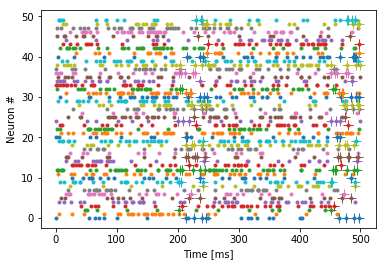

In [3]:
spike_plot_neurons = 50
spike_times_list_temp = spike_times_list[:,:250]
for n in range(spike_plot_neurons):
    spike_plot = spike_times_list_temp[n,spike_times_list_temp[n,:]<spike_plot_time]
    spike_num = spike_plot.size
    plt.plot(spike_plot,n*np.ones(spike_num),'.')

cur_pattern = np.argmax(np.sum(pattern_segment_ind<(spike_plot_time//segment_time), axis=0))
print('Pattern with most repetitions in early activity: ' + str(cur_pattern))
for n in range(spike_plot_neurons):
    spike_plot = spike_times_pattern_repeats[n,spike_times_pattern_repeats[n,:,cur_pattern]<spike_plot_time,cur_pattern]
    spike_num = spike_plot.size
    plt.plot(spike_plot, n*np.ones(spike_num), linestyle='None', marker='+', markersize=10)
    
plt.xlabel('Time [ms]')
plt.ylabel('Neuron #')
plt.show()

## Simulating neurons with STDP and lateral inhibition

An earlier study (Masquelier et al., 2008b) examined the ability of STDP with lateral inhibition to produce competitively tuned neurons that detect hidden spike patterns.
A short period of input spike activity based this earlier study has been produced.
A set of postsynaptic neurons can be simulated and their activity investigated.

### Spike-Response Neuron Model

The postsynaptic neurons are each simulated using two variables with different decay time-constants which are summed to produce a model of total neuron potential.
A presynaptic spike makes an equal but opposite contribution to the variables of a postsynaptic neuron, the difference in rates of decay causes a smooth rise and fall in the total neuron potential.
When the total postsynaptic neuron potential exceeds the neuron threshold, the neuron variables are set to spike values and the neuron has a refractory period where it cannot spike.
Examples of a the contribution of a single presynaptic spike (the excitatory postsynaptic potential) and the change in potential from a postsynaptic spike are produced from the following code block.

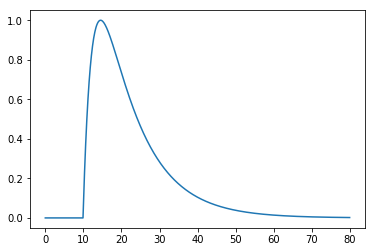

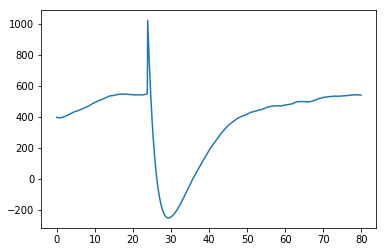

In [5]:
# Initial neuron parameters
n_post = 9

p_thr = 550.
p_rest = 0.
p_tau_m = 10.
p_tau_s = 2.5
p_spike_m = p_thr * (2-4)
p_spike_s = p_thr * 4

p_post_m = np.full(n_post, p_rest)
p_post_s = np.full(n_post, p_rest)

T_ref = 5.
K_PSP = (4**(4/3))/3
IPSP_peak = -0.25 * p_thr
IPSP = K_PSP * IPSP_peak

PSP_steps = 800
p_rec = np.zeros(PSP_steps)
dt = 1/10
for step in np.arange(PSP_steps):
    t = step/10
    if t == 10:
        p_post_m[0] =  1 * K_PSP
        p_post_s[0] = -1 * K_PSP
    
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m[0] *= p_dec_m 
    p_post_s[0] *= p_dec_s
    
    p_rec[step] = p_post_m[0] + p_post_s[0]
        
plt.plot(np.arange(PSP_steps)/10,p_rec)
plt.show()

p_post_m[0] = 500.
p_post_s[0] = -100.

PSP_steps = 800
p_rec = np.zeros(PSP_steps)
dt = 1/10
t_post_ref = 0
for step in np.arange(PSP_steps):
    t = step/10
        
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m[0] *= p_dec_m 
    p_post_s[0] *= p_dec_s
    p_rec[step] = p_post_m[0] + p_post_s[0]
    
    if (p_rec[step] >= p_thr) and (t > t_post_ref):
        t_post_ref = t + T_ref
        p_post_m[0] = p_spike_m
        p_post_s[0] = p_spike_s
        
    Dp = 2*np.random.randn() + 3.5
    p_post_m[0] +=  Dp * K_PSP
    p_post_s[0] += -Dp * K_PSP
    
plt.plot(np.arange(PSP_steps)/10,p_rec)
plt.show()

### Postsynaptic neuron simulation

Now that the presynaptic neuron activity has been generated (with concealed repeating patterns) and the postsynaptic neuron model has been defined, the simulation of postsynaptic neuron activity and synaptic plasticity can be performed. (On a quadcore i5-3570K CPU @ 3.40GHz, 16GB RAM, 3 seconds of simulated time takes about 1 minute.)

In [6]:
# reset postsynaptic potential variables
p_post_m = np.full(n_post, p_rest)
p_post_s = np.full(n_post, p_rest)

# Initial synapse parameters
w_min = 0.
w_max = 1.
w_IJ = np.random.rand(n_pre,n_post)
w_inh = 1.

# STDP parameters and variables
A_p = 0.03125
A_n = 0.85 * A_p
STDP_tau_p = 16.8
STDP_tau_n = 33.7

nearest_f_pre = np.full((n_pre,n_post), False)
nearest_f_post = np.full((n_pre,n_post), True)

# Recording and tracking neuron spike times
t_f_post_list_max = 1000
t_f_post_list = np.full((n_post,t_f_post_list_max), np.inf)
t_f_post_list_count = np.zeros((n_post), dtype='int')

long_time = 1e6
t_post_ref = np.full((n_post),-long_time)
t_f_post = np.full((n_post),-long_time)
t_f_pre = np.full((n_pre),-long_time)
t_f_pre_list_temp = spike_times_list[:,0].copy()
t_f_pre_list_count = np.zeros(n_pre, dtype='int')

t_display_next = 0
t_display_inc = 500
t = np.amin(t_f_pre_list_temp)

# Simulation loop
count_depression_updates = np.zeros(n_post, dtype='int')
count_potentiation_updates = np.zeros(n_post, dtype='int')
while any(np.not_equal(t_f_pre_list_temp, np.inf)):
    # find next presynaptic spike-time (event driven simulation)
    dt = np.amin(t_f_pre_list_temp) - t
    t = np.amin(t_f_pre_list_temp)
    n_f_pre = np.argwhere(t_f_pre_list_temp == t)
    
    if t >= t_display_next:
        print('Simulated time elapsed: ' + str(t_display_next/1000) + '/' + str(sim_time/1000) + 's')
        t_display_next += t_display_inc
        print('Spike counts: ' + str(t_f_post_list_count))
    
    # neuron potential variables decay according to time-constants
    p_dec_m = np.exp(-dt/p_tau_m)
    p_dec_s = np.exp(-dt/p_tau_s)
    p_post_m *= p_dec_m 
    p_post_s *= p_dec_s
        
    # find postsynaptic spikes
    not_ref = t > t_post_ref
    f_post = ((p_post_m + p_post_s) > p_thr) & not_ref
    if any(f_post): # if a postsynaptic neuron spikes
        # inhibit other neurons
        p_post_m[~f_post] += IPSP*w_inh
        p_post_s[~f_post] -= IPSP*w_inh
        # set neuron potentials for spikes
        p_post_m[f_post] = p_spike_m
        p_post_s[f_post] = p_spike_s
        # update refractory time
        t_post_ref[f_post] = t + T_ref
        # record spike times
        t_f_post[f_post] = t
        t_f_post_list[f_post, t_f_post_list_count[f_post]] = t 
        t_f_post_list_count[f_post] += 1
        
    # STDP: potentiate connections of active postsynaptic neurons
    for n in np.argwhere(f_post):
        Dt_f_ij = t - t_f_pre[nearest_f_post[:,n].flatten()]
        Dw = A_p * np.exp(-Dt_f_ij/STDP_tau_p)
        w_IJ[nearest_f_post[:,n].flatten(),n] = np.minimum(w_max, w_IJ[nearest_f_post[:,n].flatten(),n] + Dw)
        nearest_f_pre[:,n] = True
        nearest_f_post[:,n] = False
    
    # STDP: depress connections of active presynaptic neurons
    for n in n_f_pre:
        for p in np.argwhere(nearest_f_pre[n,:].flatten()):
            Dt_f_ij = t_f_post[p] - t
            Dw = -A_n * np.exp(Dt_f_ij/STDP_tau_n)
            w_IJ[n,p] = np.maximum(w_min, w_IJ[n,p] + Dw)
        nearest_f_pre[n,:] = False
        nearest_f_post[n,:] = True
    
    Dp = K_PSP * np.sum(w_IJ[n_f_pre,:],axis=0)
    p_post_m += Dp.flatten()
    p_post_s -= Dp.flatten()
    
    t_f_pre[n_f_pre] = t
    t_f_pre_list_count[n_f_pre] += 1
    t_f_pre_list_temp[n_f_pre] = spike_times_list[n_f_pre,t_f_pre_list_count[n_f_pre]].copy()
    
print('Simulated time elapsed: ' + str(sim_time/1000) + '/' + str(sim_time/1000) + 's')
print('Simulation complete')

Simulated time elapsed: 0.0/67.5s
Spike counts: [0 0 0 0 0 0 0 0 0]
Simulated time elapsed: 0.5/67.5s
Spike counts: [12 10 11 12 12 12 12 12 10]
Simulated time elapsed: 1.0/67.5s
Spike counts: [23 21 21 23 23 23 24 23 21]
Simulated time elapsed: 1.5/67.5s
Spike counts: [33 30 31 33 33 33 34 34 31]
Simulated time elapsed: 2.0/67.5s
Spike counts: [43 39 40 44 43 42 45 44 39]
Simulated time elapsed: 2.5/67.5s
Spike counts: [50 49 50 53 52 50 54 54 48]
Simulated time elapsed: 3.0/67.5s
Spike counts: [58 56 58 61 59 59 64 61 55]
Simulated time elapsed: 3.5/67.5s
Spike counts: [67 62 66 68 68 67 73 69 60]
Simulated time elapsed: 4.0/67.5s
Spike counts: [75 68 74 75 76 73 79 76 65]
Simulated time elapsed: 4.5/67.5s
Spike counts: [81 75 80 83 81 79 87 81 73]
Simulated time elapsed: 5.0/67.5s
Spike counts: [86 82 87 90 87 85 95 85 78]
Simulated time elapsed: 5.5/67.5s
Spike counts: [ 90  89  91  96  93  92 100  92  83]
Simulated time elapsed: 6.0/67.5s
Spike counts: [ 96  93  95 101 101  97 105

Simulated time elapsed: 48.0/67.5s
Spike counts: [184 230 210 221 190 180 219 218 215]
Simulated time elapsed: 48.5/67.5s
Spike counts: [184 231 211 223 191 180 220 221 217]
Simulated time elapsed: 49.0/67.5s
Spike counts: [184 232 212 224 192 180 221 223 219]
Simulated time elapsed: 49.5/67.5s
Spike counts: [184 232 212 225 192 180 222 225 221]
Simulated time elapsed: 50.0/67.5s
Spike counts: [184 234 214 226 194 180 223 226 222]
Simulated time elapsed: 50.5/67.5s
Spike counts: [184 234 214 228 194 180 225 226 222]
Simulated time elapsed: 51.0/67.5s
Spike counts: [184 235 215 229 195 180 226 228 224]
Simulated time elapsed: 51.5/67.5s
Spike counts: [184 237 218 230 197 180 227 228 224]
Simulated time elapsed: 52.0/67.5s
Spike counts: [184 240 221 232 200 180 229 228 224]
Simulated time elapsed: 52.5/67.5s
Spike counts: [184 241 222 234 201 180 231 229 224]
Simulated time elapsed: 53.0/67.5s
Spike counts: [184 241 222 235 201 180 232 230 225]
Simulated time elapsed: 53.5/67.5s
Spike co

### Postsynaptic neuron activity

Once the simulation has been completed and the postsynaptic neuron spike-times have been recorded, the activity of the postsynaptic neurons can be examined.
The first plot shows the rate of postsynaptic neuron activity over time.
All of the postsynaptic neurons respond randomly at first and spike regularly.
The spike-timing-dependent plasticity rule gradually decreases the overall input weight to the postsynaptic neurons and the neurons either become selectively responsive to a small set of active neurons (the neurons in a hidden pattern) or become unresponsive.

The next set of plots show the latency of the postsynaptic neurons to the repetitions of hidden patterns.
Each repetition of a pattern lasts for 50ms, postsynaptic spikes that do not occur inside any repetition of a hidden pattern are presented as having a latency of 0ms.
Neurons typically have an initial period of spiking randomly inside and outside the repetitions of a spike pattern.
Then the postsynaptic neuron either tunes to a set of neurons that are active in one of the repeating spike patterns and have a consistent latency for that spike-pattern or the postsynaptic neuron ceases to respond.

Display postsynatpic spike trains


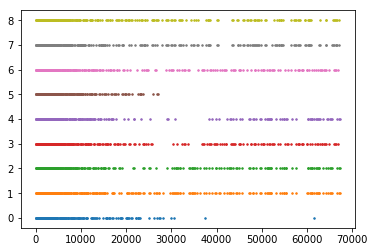

Display postsynaptic neuron spike latencies relative to pattern repetitions


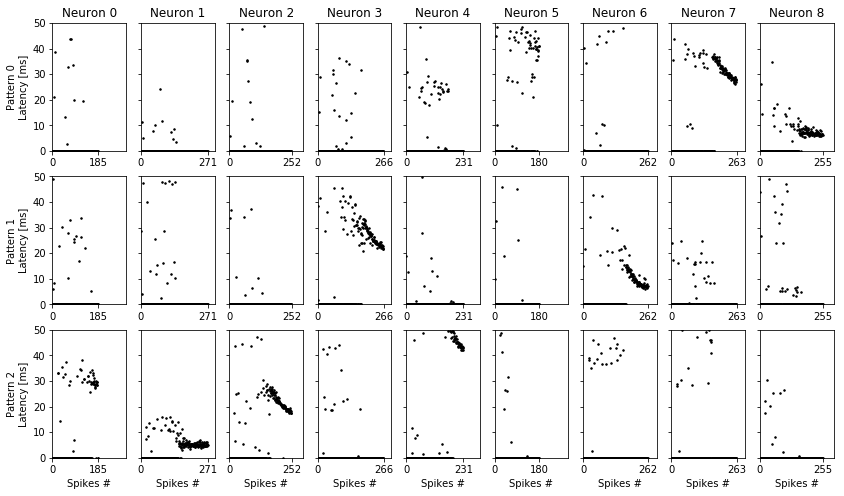

In [7]:
print('Display postsynatpic spike trains')
for n in range(n_post):
    plt.plot(t_f_post_list[n,range(t_f_post_list_count[n])],
             np.full((t_f_post_list_count[n]), n),
             '.', markersize=3)
plt.show()

print('Display postsynaptic neuron spike latencies relative to pattern repetitions')
subp_i = 0;
fig = plt.figure(figsize = (14,8))
fig.subplots(nrows=pattern_n,ncols=n_post)
for p in range(pattern_n):
    for n in range(n_post):
        t_post_latency = np.zeros(t_f_post_list_count[n])
        p_rep = 0
        for f in range(t_f_post_list_count[n]):
            while t_f_post_list[n,f] > ((pattern_segment_ind[p_rep,p]+1)*segment_time):
                if p_rep < pattern_repeat_n-1:
                    p_rep += 1
                else:
                    break
            tpl = t_f_post_list[n,f] - (pattern_segment_ind[p_rep,p]*segment_time)
            if tpl > 0 and tpl < segment_time:
                t_post_latency[f] = tpl
        #print('Neuron: ' + str(n) + '; Pattern: ' + str(p))
        subp_i += 1
        plt.subplot(pattern_n, n_post, subp_i)
        plt.plot(np.arange(t_f_post_list_count[n]), t_post_latency, 'k.', markersize=3)
        plt.ylim((0,50))
        plt.xlim((0,np.amax(t_f_post_list_count)*1.1))
        plt.xticks([0, t_f_post_list_count[n]])
        if p == 0:
            plt.title('Neuron ' + str(n))
        if p == pattern_n-1:
            plt.xlabel('Spikes #')
        if n != 0:
            locs, labels = plt.yticks()
            plt.yticks(locs, {})
        else:
            plt.ylabel('Pattern ' + str(p) + '\nLatency [ms]')

plt.show()

## Postsynaptic neuron construction

The first simulation of postsynaptic neurons initialised 9 neurons with random synapse weights then the activity of the presynaptic and postsynaptic neurons combined with STDP resulted in the neurons tuning to spike patterns concealed within the presynaptic activity.
The next simulation will construct postsynaptic neurons in one shot with synapse weights selected using a prediction of the convergence of STDP for those relative spike-times.

The initial number of neurons simulated will be zero.
Because there is a consistently high rate of neuron activity in the presynaptic activity, a simple way to detect whether the activity contains a repeating pattern from a single observation is not obvious.
Therefore, postsynaptic neurons will be constructed every 15ms or 15ms after the last postsynaptic neuron spike.
A spike from a simulated postsynaptic neuron within 15ms of the construction of a postsynaptic neuron will cancel that neuron construction.
A neuron that is constructed and does not spike at a least a rate of 1Hz in the first 5s of simulation is also considered insufficiently tuned to a pattern or insignificant and is pruned.

Additive models of STDP have a tendency to produce synapse weights that are clustered near the minimum and maximum values.
Constructed neurons have the synapses from the most recent presynaptic neurons to spike potentiated to the maximum value while all other synapses are depressed to the minimum value.
The total input weight of a postsynaptic neuron after tuning has been found tends to be less than 450; however, an initial total input weight of 450 has been found in other experiments to reliably produce neurons that are selective to patterns in presynpatic activity.

In [ ]:
# Code to be completed